In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import gudhi as gd
from tqdm import tqdm
from gudhi.tensorflow import LowerStarSimplexTreeLayer, CubicalLayer, RipsLayer

C:\Users\Seungyun\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Point cloud

In [2]:
np.random.seed(1)
Xinit = np.array(np.random.uniform(high=1.,low=-1.,size=(300,2)), dtype=np.float32)

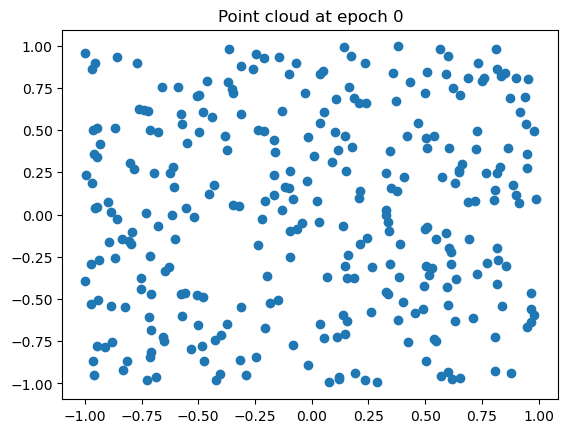

In [3]:
plt.figure()
plt.scatter(Xinit[:,0], Xinit[:,1])
plt.title('Point cloud at epoch 0')
plt.show()

In [4]:
st = gd.RipsComplex(points=Xinit, max_edge_length=1.).create_simplex_tree(max_dimension=2)
dgm = st.persistence()

usetex mode requires ghostscript.


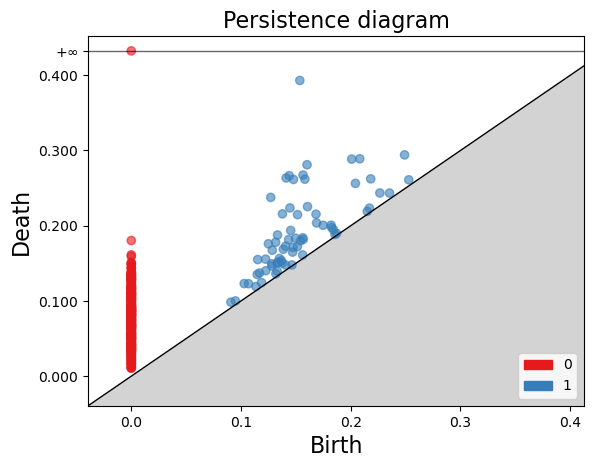

In [5]:
plot = gd.plot_persistence_diagram(dgm)

In [6]:
X = tf.Variable(initial_value=Xinit, trainable=True)
layer = RipsLayer(maximum_edge_length=1., homology_dimensions=[1])

In [7]:
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.)

In [11]:
losses, dgms = [], []

for epoch in tqdm(range(200+1)):
    with tf.GradientTape() as tape:
        dgm = layer.call(X)[0][0]
        persistence_loss = -tf.math.reduce_sum(tf.square((dgm[:,1] - dgm[:,0])/2))
        regularization = tf.reduce_sum(tf.maximum(tf.abs(X)-1, 0))
        loss = persistence_loss + regularization
    gradients = tape.gradient(loss, [X])
    
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0, scale=.001, size = gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [X]))
    losses.append(loss.numpy())
    dgms.append(dgm)

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [01:25<00:00,  2.34it/s]


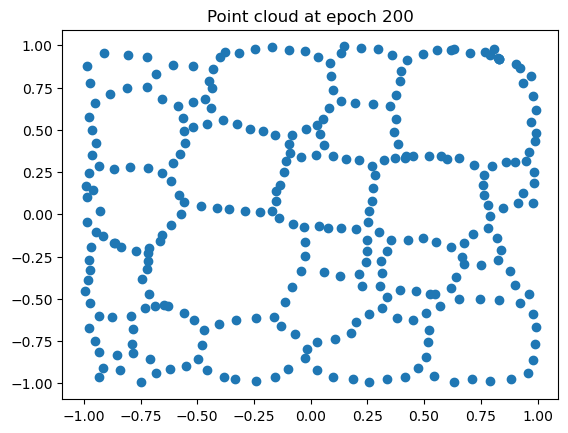

In [12]:
plt.figure()
plt.scatter(X.numpy()[:,0], X.numpy()[:,1])
plt.title('Point cloud at epoch ' + str(epoch))
plt.show()

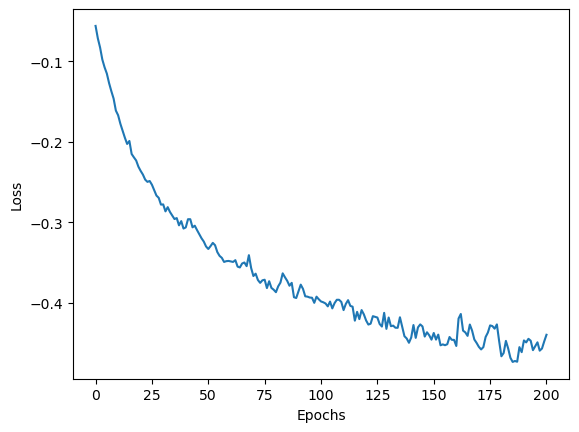

In [13]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

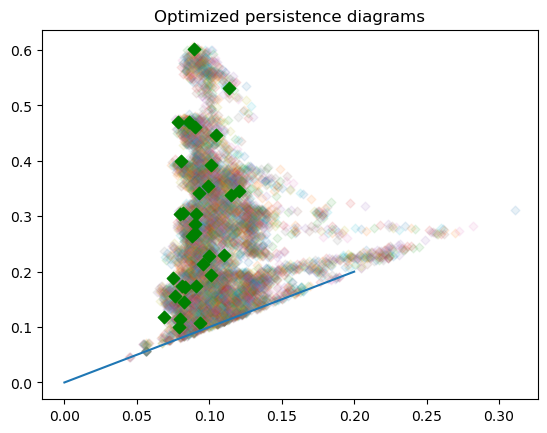

In [14]:
plt.figure()
for dg in dgms[:5:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='green')
plt.plot([-0.,.2], [-0.,.2])
plt.title('Optimized persistence diagrams')
plt.show()

### Image

In [18]:
I = np.array(pd.read_csv('../datasets/mnist_test.csv', header=None, sep=','), dtype=np.float32)
idx = np.argwhere(I[:,0] == 8)
image = np.reshape(-I[idx[8],1:], [28,28])
image = (image-image.min())/ (image.max()-image.min())
image_clean = np.array(image)
image[2:5,2:5] -= 0.4
image[25:27,25:27] -= 0.4
image[25:27,2:5] -= 0.4
image[1:4,24:26] -= 0.4
image = image[:,1:]

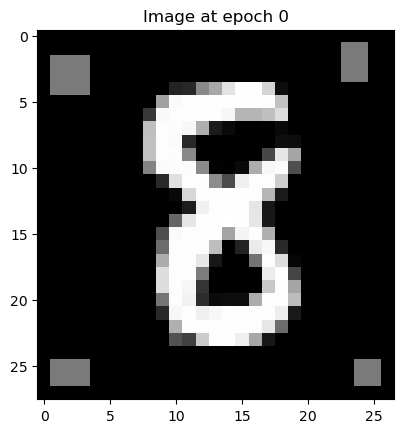

In [19]:
plt.figure()
plt.imshow(image, cmap='Greys')
plt.title('Image at epoch 0')
plt.show()

In [20]:
X = tf.Variable(initial_value=np.array(image, dtype=np.float32), trainable=True)
layer = CubicalLayer(homology_dimensions=[0])

In [21]:
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-3, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

In [23]:
losses, dgms = [], []

for epoch in range(500+1):
    with tf.GradientTape() as tape:
        dgm = layer.call(X)[0][0]
        
        persistence_loss = 10*tf.math.reduce_sum(tf.abs(dgm[:,1]-dgm[:,0]))
        
        regularization = tf.math.reduce_sum(tf.math.minimum(tf.abs(X), tf.abs(1-X)))
        loss = persistence_loss + regularization
        
    gradients = tape.gradient(loss, [X])
    
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0, scale=0.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [X]))
    losses.append(loss.numpy())
    dgms.append(dgm)

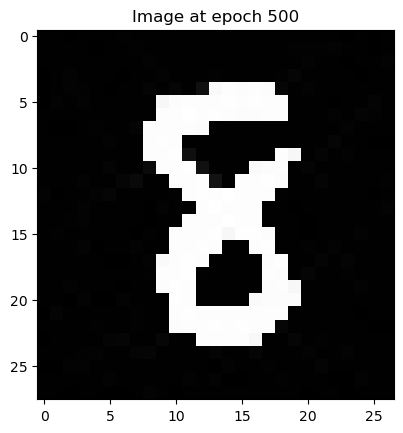

In [24]:
plt.figure()
plt.imshow(X.numpy(), cmap='Greys')
plt.title('Image at epoch ' + str(epoch))
plt.show()

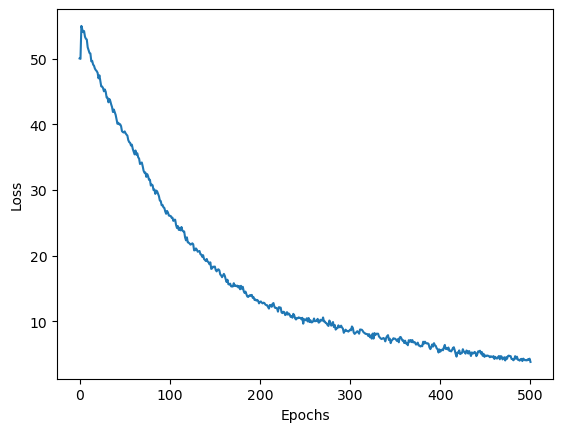

In [25]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

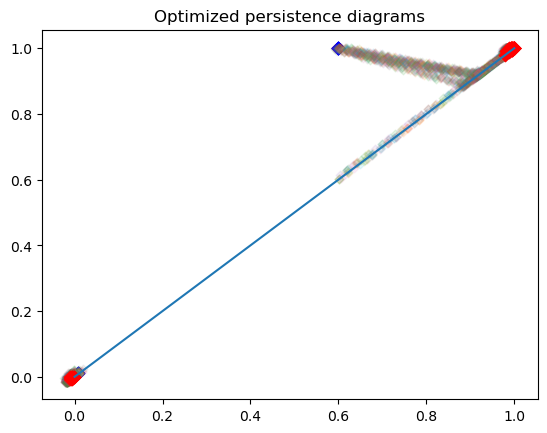

In [26]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([0,1], [0,1])
plt.title('Optimized persistence diagrams')
plt.show()

### Regression

In [27]:
np.random.seed(0)
n, p = 50, 100
betastar = np.concatenate([np.linspace(-1.,1.,33) for _ in range(3)] + [[-1.]])

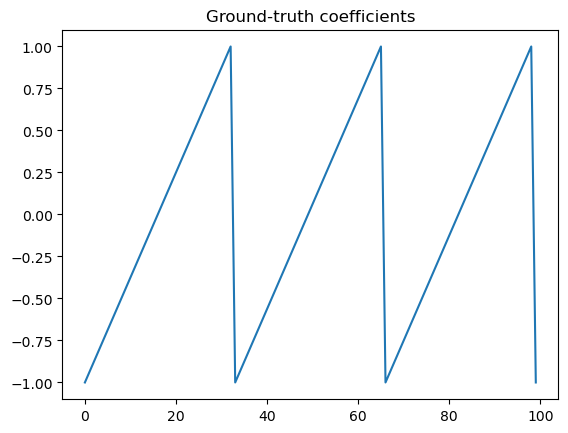

In [28]:
plt.figure()
plt.plot(betastar)
plt.title('Ground-truth coefficients')
plt.show()

In [29]:
X = np.array(np.random.multivariate_normal(mean=np.zeros(shape=[p]), cov=np.eye(p), size=n), dtype=np.float32)
Y = np.array(np.matmul(X, betastar) + .05 * np.random.randn(n), dtype=np.float32)

In [30]:
stbase = gd.SimplexTree()
for i in range(p-1):
    stbase.insert([i,i+1], -1e10)

In [31]:
betainit = np.random.uniform(low=-1., high=1., size=[p])
betainit[np.array([25,60,99])] = np.array([-1,-1,-1])

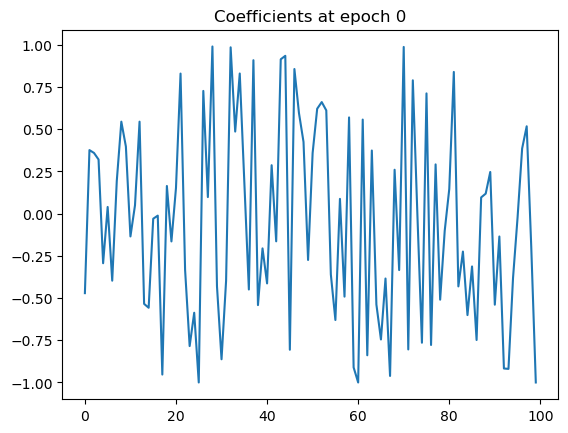

In [32]:
plt.figure()
plt.plot(betainit)
plt.title('Coefficients at epoch 0')
plt.show()

In [36]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses, betas = [], []
for epoch in range(100+1):
    with tf.GradientTape() as tape:
        loss = 2 * tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y))
    gradients = tape.gradient(loss, [beta])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)    

    optimizer.apply_gradients(zip(gradients, [beta]))
    losses.append(loss.numpy())
    betas.append(beta.numpy()[:,0])
    
beta_std = -betas[-1]

In [37]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses, betas = [], []
for epoch in range(100+1):
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
             + 1e3 * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
    gradients = tape.gradient(loss, [beta])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)

    optimizer.apply_gradients(zip(gradients, [beta]))
    losses.append(loss.numpy())
    betas.append(beta.numpy()[:,0])
                 
beta_stdtot = -betas[-1]

In [38]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
layer = LowerStarSimplexTreeLayer(simplextree=stbase, homology_dimensions=[0])
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses, dgms, betas = [], [], []
for epoch in range(100+1):    
    with tf.GradientTape() as tape:
        dgm = layer.call(beta)[0][0]
        # Minimize all points except the three most persistent ones
        top3 = np.argsort(dgm[:,1]-dgm[:,0]).ravel()[::-1][3:]
        loss =  tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
             + 1e4 * tf.reduce_sum(tf.abs(tf.gather_nd(dgm[:,1]-dgm[:,0], [[idx] for idx in top3]))) \
             + 1e3 * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
    gradients = tape.gradient(loss, [beta])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [beta]))
    losses.append(loss.numpy())
    dgms.append(dgm)
    betas.append(beta.numpy()[:,0])

beta_stdtop = -betas[-1]

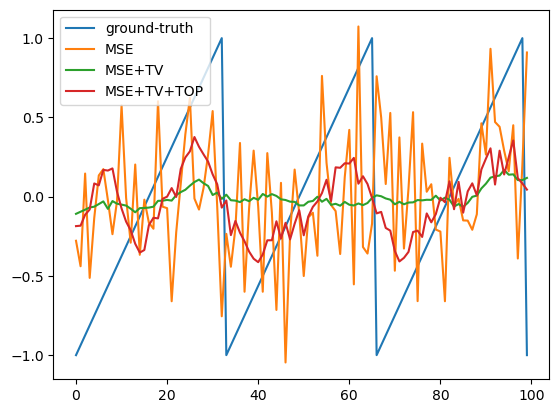

In [39]:
plt.figure()
plt.plot(betastar, label='ground-truth')
plt.plot(beta_std, label='MSE')
plt.plot(beta_stdtot, label='MSE+TV')
plt.plot(beta_stdtop, label='MSE+TV+TOP')
plt.legend(loc='upper left')
plt.show()

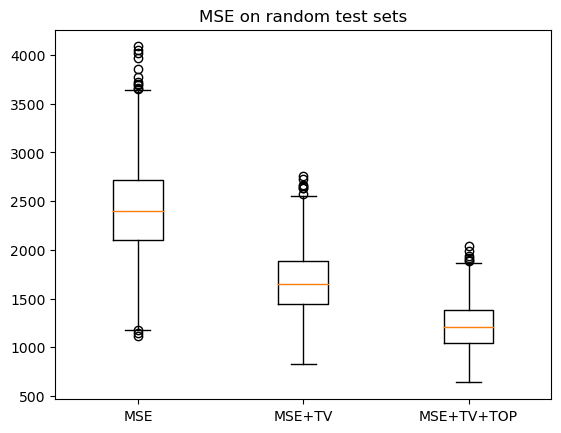

In [40]:
MSEstd, MSEtop, MSEtot = [], [], []
for s in range(1000):
    np.random.seed(s)
    Xnew = np.random.multivariate_normal(mean=np.zeros(shape=[p]), cov=np.eye(p), size=n)
    Ynew = np.matmul(Xnew, betastar)
    mse_std = np.square(np.matmul(Xnew, beta_std) - Ynew).sum()
    mse_tot = np.square(np.matmul(Xnew, beta_stdtot) - Ynew).sum()
    mse_top = np.square(np.matmul(Xnew, beta_stdtop) - Ynew).sum()
    MSEstd.append(mse_std)
    MSEtot.append(mse_tot)
    MSEtop.append(mse_top)
    
plt.figure()
plt.boxplot([MSEstd, MSEtot, MSEtop], labels=['MSE', 'MSE+TV', 'MSE+TV+TOP'])
plt.title('MSE on random test sets')
plt.show()

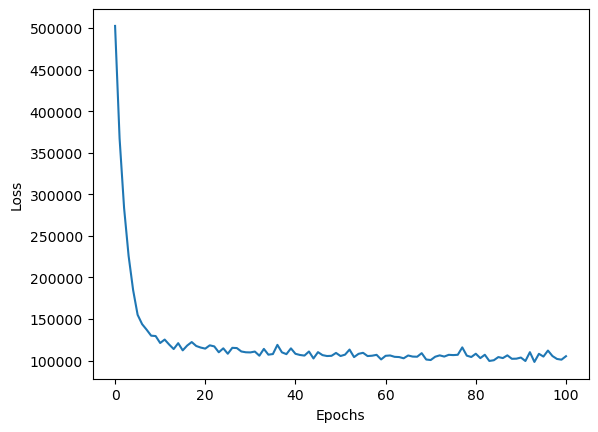

In [41]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

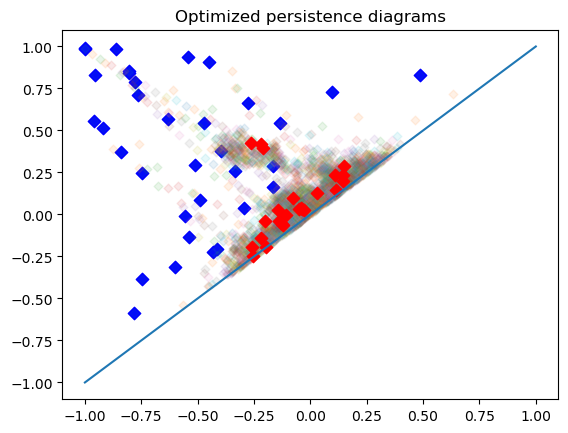

In [42]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([-1,1], [-1,1])
plt.title('Optimized persistence diagrams')
plt.show()